In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import exp
import os, time

In [7]:
df = pd.read_csv('DataBase.csv')
df

,time,pressure,derivative,blowing,start_blow,stop_blow
0,0.0,41.299880,0.372273,False,False,False
1,0.1,41.316720,0.315617,False,False,False
2,0.2,41.332510,0.260945,False,False,False
3,0.3,41.344340,0.205060,False,False,False
4,0.4,41.352390,0.153722,False,False,False
...,...,...,...,...,...,...
6095,609.0,30.442043,-0.105082,False,False,False
6096,609.1,30.433882,-0.098400,False,False,False
6097,609.2,30.425503,-0.092150,False,False,False
6098,609.3,30.419050,-0.082493,False,False,False


# OBTENDO A VARIAVEL DESEJADA
Os valores de início e fim de sopro são os pontos discretizados ao longo do gráfico, o objetivo do modelo é encontrar o momento que iniciou o sopro, e o momento que não há mais sopro

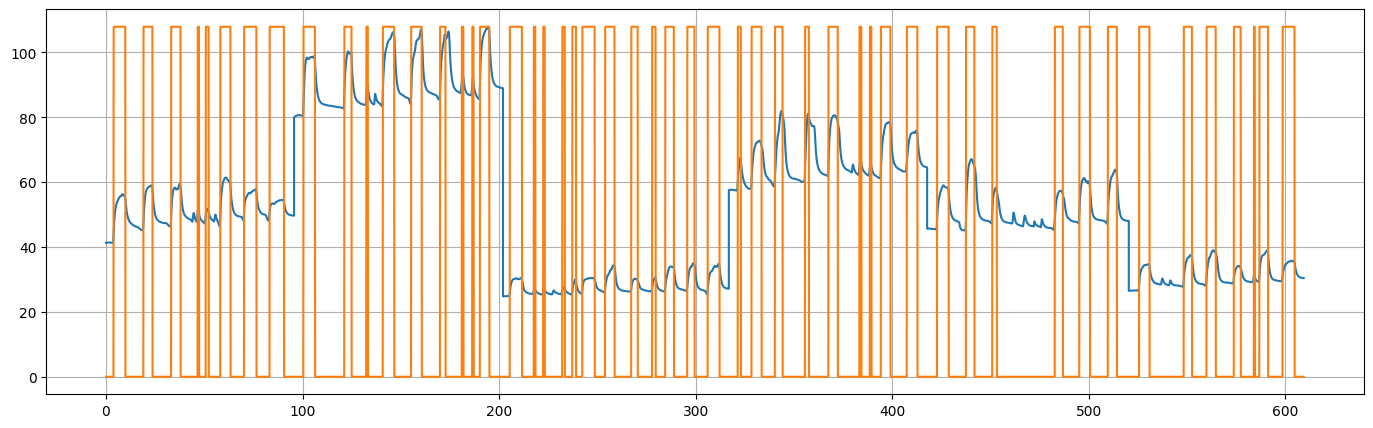

In [8]:
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.blowing * df.pressure.max())
plt.grid()

In [9]:
startCount = (df.start_blow == True).sum() / len(df) * 100
stopCount  = (df.stop_blow == True).sum()  / len(df)  * 100
total = int((startCount + stopCount) * len(df) / 100)

print(f'{startCount:.2f}% dos dados inicio de sopro')
print(f'{stopCount:.2f}% dos dados término de sopro')
print(f'total: {startCount + stopCount:.2f}% ({total} dados)')

7.57% dos dados inicio de sopro
16.00% dos dados término de sopro
total: 23.57% (1438 dados)


# SEPARAÇÃO DOS DADOS
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [10]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}n'] = table[key]

    for i in range(1, n):
        table[f'{var}n{i}'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}n'] + [f'{var}n{i}' for i in range(1, n)]
    return table[columns]


def getTrainData(df, n=2):
    pressureStates   = getStates(df, 'pressure', 'P', n)
    derivativeStates = getStates(df, 'derivative', 'D', n)
    return pd.concat([pressureStates, derivativeStates], axis=1)


n = 5
xData = getTrainData(df, n)
xData.head(10)

,Pn,Pn1,Pn2,Pn3,Pn4,Dn,Dn1,Dn2,Dn3,Dn4
0,41.29988,0.00000,0.00000,0.00000,0.00000,0.372273,0.000000,0.000000,0.000000,0.000000
1,41.31672,41.29988,0.00000,0.00000,0.00000,0.315617,0.372273,0.000000,0.000000,0.000000
2,41.33251,41.31672,41.29988,0.00000,0.00000,0.260945,0.315617,0.372273,0.000000,0.000000
3,41.34434,41.33251,41.31672,41.29988,0.00000,0.205060,0.260945,0.315617,0.372273,0.000000
4,41.35239,41.34434,41.33251,41.31672,41.29988,0.153722,0.205060,0.260945,0.315617,0.372273
5,41.35808,41.35239,41.34434,41.33251,41.31672,0.116414,0.153722,0.205060,0.260945,0.315617
6,41.36486,41.35808,41.35239,41.34434,41.33251,0.096288,0.116414,0.153722,0.205060,0.260945
7,41.37194,41.36486,41.35808,41.35239,41.34434,0.078877,0.096288,0.116414,0.153722,0.205060
8,41.37756,41.37194,41.36486,41.35808,41.35239,0.066434,0.078877,0.096288,0.116414,0.153722
9,41.38345,41.37756,41.37194,41.36486,41.35808,0.062138,0.066434,0.078877,0.096288,0.116414


# MODELO LOGISTIC REGRESSION
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import random

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [12]:
def getModel(xData, yData, trainSize=0.20):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=trainSize)
    model = LogisticRegression(class_weight='balanced')
    model.fit(xTreino, yTreino)
    yModel = model.predict(xTeste)
    score  = accuracy_score(yTeste, yModel) 
    return model, score


def getBestModel(xData, yData, timeout=5):
    trainSizes = np.arange(0.12, 0.35, 0.01)
    startTime  = time.time()
    bestModel  = [0, 0]

    while time.time() - startTime < timeout:
        for size in trainSizes: 
            model, score = getModel(xData, yData, size)
            yModel = model.predict(xData)
            score  = accuracy_score(yData, yModel) 

            if score > bestModel[1]:
                print(f'melhor score: {score*100:.2f}% | train size: {size:.2f}')
                bestModel = model, score

            if score == 1.0:
                return bestModel

    return bestModel


def plotModel(yTest, yModel, title=''):
    global classNames
    confusionMatrix = confusion_matrix(yTest, yModel)
    score = accuracy_score(yTest, yModel)

    plt.figure(figsize=(10, 5))
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Predicted Label'), plt.ylabel('True Label')
    plt.title(f'Precisão do Modelo: {title} {score*100:.2f}%')
    plt.show()

# MODELO START BLOWING

In [13]:
yData = df.start_blow.values

In [14]:
model, score = getBestModel(xData, yData, timeout=20)
model, score

melhor score: 97.92% | train size: 0.12
melhor score: 97.93% | train size: 0.13
melhor score: 97.97% | train size: 0.30
melhor score: 98.00% | train size: 0.34
melhor score: 98.02% | train size: 0.31


(LogisticRegression(class_weight='balanced'), 0.9801639344262295)

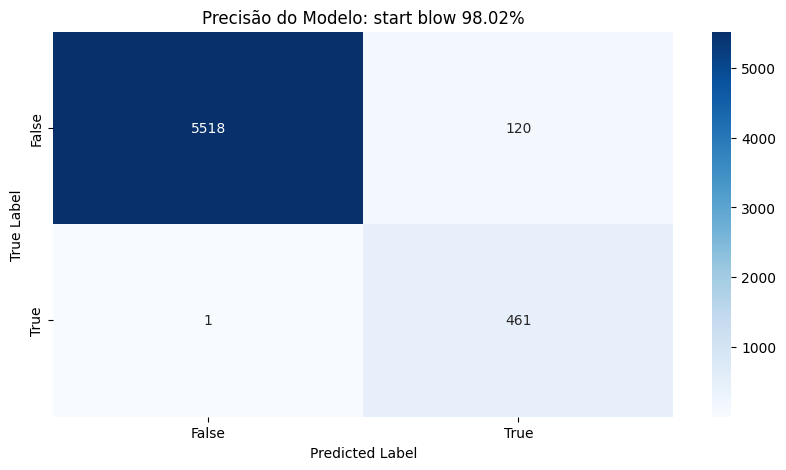

In [15]:
df['start_blow_pred'] = model.predict(xData)
blowingModel = model

classNames = model.classes_
plotModel(df.start_blow, df.start_blow_pred, 'start blow')

# MODELO STOP BLOWING

In [16]:
yData = df.stop_blow.values

In [17]:
model, score = getBestModel(xData, yData, timeout=20)
model, score

melhor score: 97.25% | train size: 0.12
melhor score: 97.28% | train size: 0.13
melhor score: 97.34% | train size: 0.16
melhor score: 97.36% | train size: 0.13
melhor score: 97.38% | train size: 0.26


(LogisticRegression(class_weight='balanced'), 0.9737704918032787)

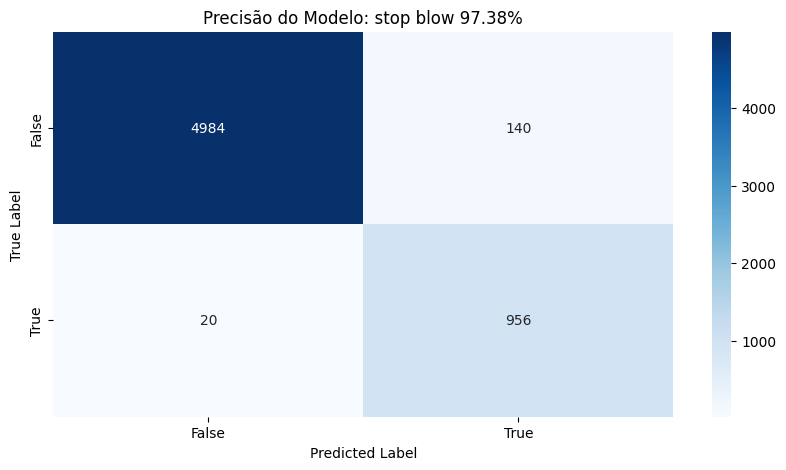

In [18]:
df['stop_blow_pred'] = model.predict(xData)
notBlowingModel = model

plotModel(df.stop_blow, df.stop_blow_pred, 'stop blow')

# JUNTANDO MODELOS

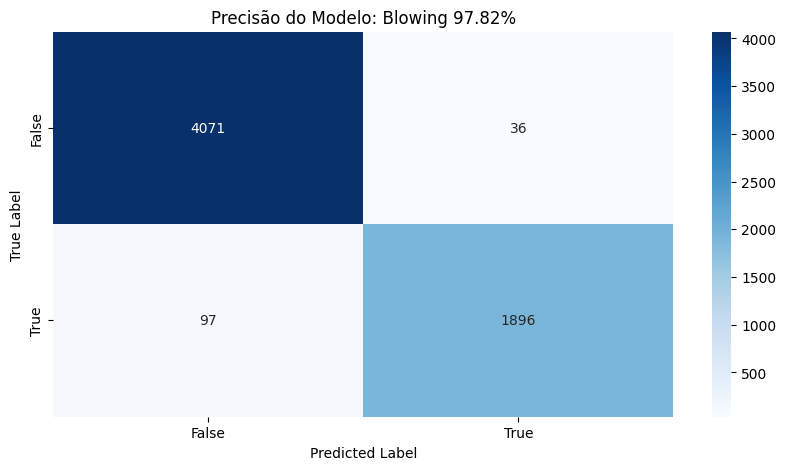

In [19]:
is_blowing = False

def isBlowing(start, end):
    global is_blowing

    if start:
        is_blowing = True

    if end:
        is_blowing = False

    return is_blowing


df    = pd.read_csv('DataBase.csv')
xData = getTrainData(df, n)

df['start_blow_pred'] = blowingModel.predict(xData)
df['stop_blow_pred']  = notBlowingModel.predict(xData)
df['prediction']      = df.apply(lambda row: isBlowing(row.start_blow_pred, row.stop_blow_pred), axis=1)
plotModel(df.prediction, df.blowing, 'Blowing')

# IMPLEMENTANDO O MODELO
Para implementar digitalmente em um arduino, o modelo LogisticRegression obedece a seguinte fórmula:
$$p = \frac{1}{1 + e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2 + ....)}}$$

In [20]:
def getModelString(model):
    coefs = model.coef_[0]
    intercept = model.intercept_[0]
    variables = model.feature_names_in_
    
    text = f'(1.0 / (1.0 + exp(-({intercept:.6f}'

    for i, column in enumerate(variables):
        text += f' + {column}*({coefs[i]:6f})'
    
    return text + '))))'


model.classes_

array([False,  True])

In [21]:
blowString  = getModelString(blowingModel)
nBlowString = getModelString(notBlowingModel)

print(f'const float pBlow    = {blowString};')
print(f'const float pNotBlow = {nBlowString};')
print()

const float pBlow    = (1.0 / (1.0 + exp(-(-0.017226 + Pn*(-0.151969) + Pn1*(0.039063) + Pn2*(-0.045935) + Pn3*(0.031468) + Pn4*(-0.061814) + Dn*(2.018047) + Dn1*(1.053401) + Dn2*(-0.009734) + Dn3*(-0.452970) + Dn4*(0.186157)))));
const float pNotBlow = (1.0 / (1.0 + exp(-(-1.589036 + Pn*(-0.354714) + Pn1*(0.175754) + Pn2*(0.079528) + Pn3*(0.019334) + Pn4*(-0.069363) + Dn*(-5.994684) + Dn1*(-1.438675) + Dn2*(0.491984) + Dn3*(0.406370) + Dn4*(-0.122158)))));



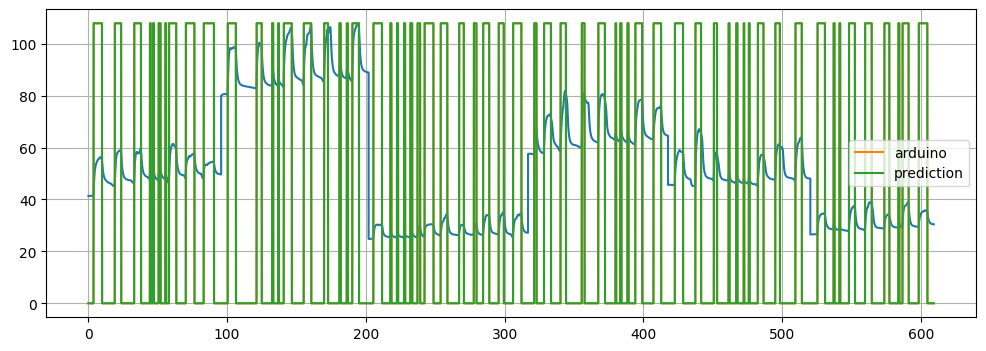

In [22]:
Pn1 = Pn2 = Pn3 = Pn4 = 0
Dn1 = Dn2 = Dn3 = Dn4 = 0
is_blowing = False

def isBlowing(pressure, derivative):
    global Pn1, Pn2, Pn3, Pn4
    global Dn1, Dn2, Dn3, Dn4
    global is_blowing
    Pn = pressure
    Dn = derivative

    pBlow    = eval(blowString)
    pNotBlow = eval(nBlowString)
    
    if pBlow > 0.5:
        is_blowing = True

    if pNotBlow > 0.5:
        is_blowing = False

    Pn4, Pn3, Pn2, Pn1 = Pn3, Pn2, Pn1, Pn
    Dn4, Dn3, Dn2, Dn1 = Dn3, Dn2, Dn1, Dn
    return is_blowing


df['arduino'] = df.apply(lambda row: isBlowing(row.pressure, row.derivative), axis=1)
plt.figure(figsize=(12, 4))
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.arduino    * df.pressure.max(), label='arduino')
plt.plot(df.time, df.prediction * df.pressure.max(), label='prediction')
plt.legend()
plt.grid()

# AVALIAÇÃO GERAL

files\test_1.csv


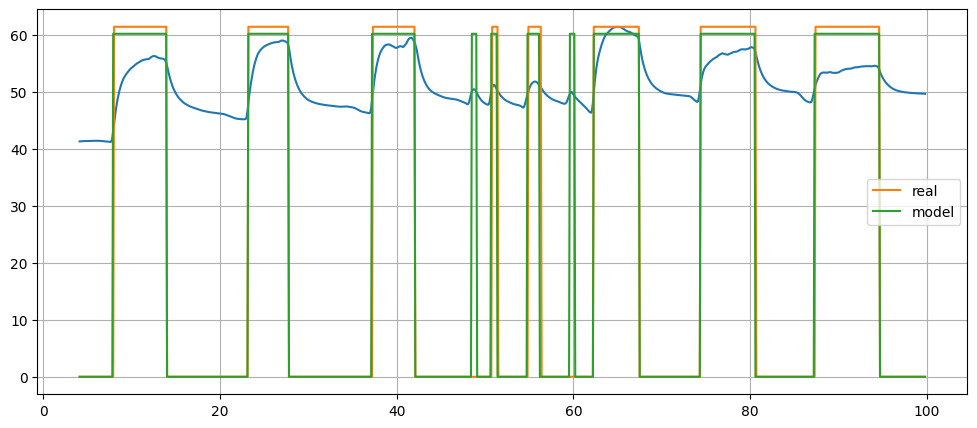

files\test_2.csv


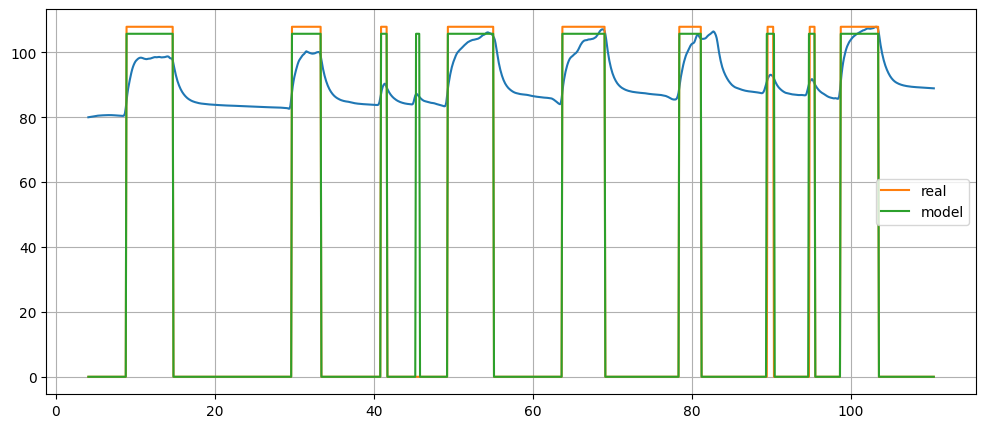

files\test_3.csv


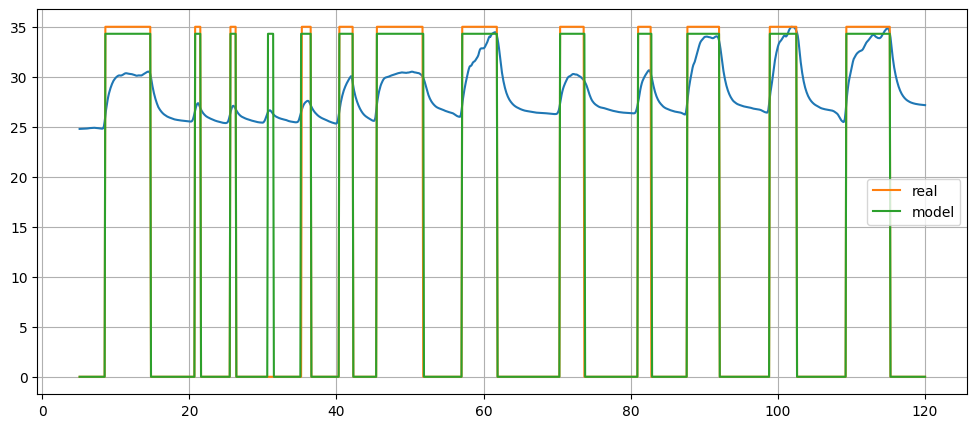

files\test_4.csv


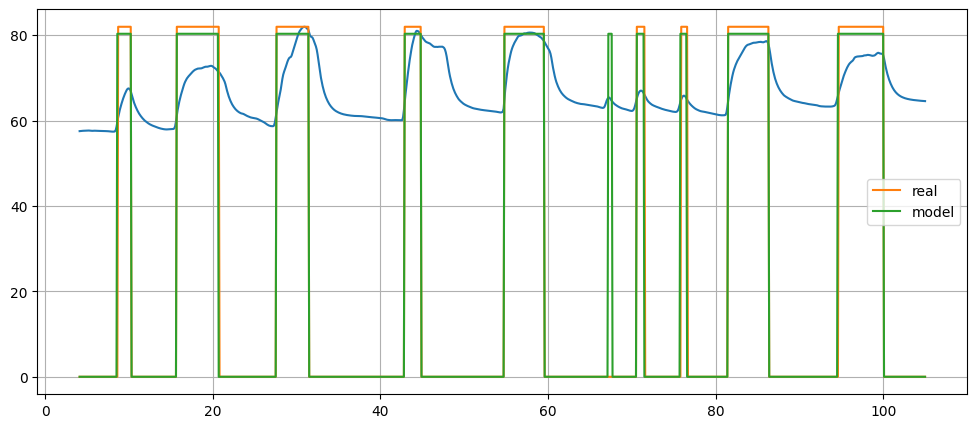

files\test_5.csv


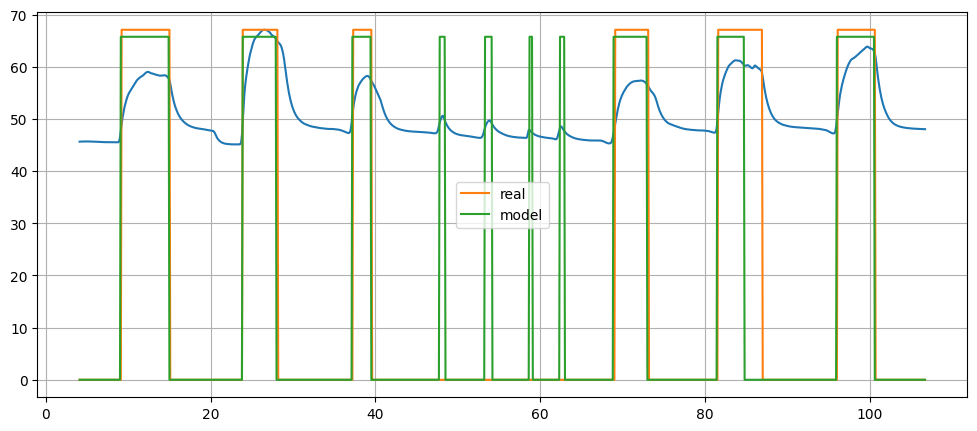

files\test_6.csv


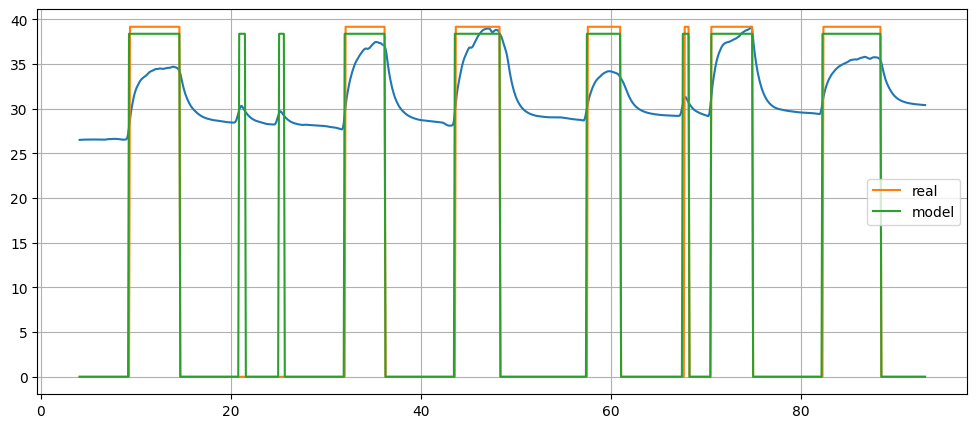

In [23]:
def getFilesFrom(baseDir):
    files = []
    
    for file in os.listdir(baseDir):
        if '.csv' not in file:
            continue

        filePath = os.path.join(baseDir, file) if baseDir else file
        files.append(filePath)

    return files


for filePath in getFilesFrom('files'):
    df = pd.read_csv(filePath)
    is_blowing = False
    df['arduino'] = df.apply(lambda row: isBlowing(row.pressure, row.derivative), axis=1)
    
    plt.figure(figsize=(12, 5))
    print(filePath)
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * max(df.pressure), label='real')
    plt.plot(df.time, df.arduino * 0.98 * max(df.pressure), label='model')
    plt.legend(), plt.grid(), plt.show()